# 卷积自编码器
卷积自编码器（CAE）的编码器和解码器都是 CNN 网络，编码器的卷积网络学习将输入编码为一组信号，然后解码器 CNN 尝试重构来自自动编码机的输入。其中 CNN 作为通用特征提取器进行工作，学习如何最好地捕捉输入特征。

通过前面的学习我们知道，随着卷积层的添加，传递到下一层的空间尺寸信息在减小，但是在自编码器中，重构图像的大小和深度应与输入图片相同，这意味着解码器应该以某种方式调整图像大小和卷积来重构原始图像。

转置卷积层能够增加空间尺寸和卷积，在 TensorFlow 中通过 tf.nn.conv2d_transpose 即可实现，但是转置卷积层会导致最终图像中出现伪影。Augustus Odena 等人表明使用最近邻或双线性插值（上采样）紧跟着一个卷积层的方式可以避免这些伪影，他们采用最近邻差值（tf.image.resize_images）实现，最终取得了非常好的结果，在这里将使用相同的方法。

## 实例：使用CAE实现MNIST数据集的压缩与重构

1. 导入模块

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
%matplotlib inline

2. 加载MNIST数据集

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


3. 定义网络参数，同时也计算每个最大池化层的输出空间维度，这些信息在解码器网络中对图像进行上采样

In [3]:
# 网络参数
h_in = w_in = 28    # 图像高度和宽度
k = 3   # 卷积核尺度
p = 2   # 池化层尺度
s = 2   # 池化核偏移量
filters = {1: 32, 2:32, 3:16}
activation_fn = tf.nn.relu

# 最大池化层后的图像高度和宽度
h_l2 = int(np.ceil(float(h_in) / float(s)))
w_l2 = int(np.ceil(float(w_in) / float(s)))
h_l3 = int(np.ceil(float(h_l2) / float(s)))
w_l3 = int(np.ceil(float(w_l2) / float(s)))

4. 为输入（噪声图像）和目标（对应的清晰图像）创建占位符

In [4]:
# X_noisy = tf.placeholder(dtype=tf.float32, shape=[None, h_in, w_in, 1], name='inputs')
X = tf.placeholder(dtype=tf.float32, shape=[None, h_in, w_in, 1], name='targets')

5. 建立编码器和解码器网络

In [5]:
# Encoder
conv1 = tf.layers.conv2d(X, filters[1], (k, k), padding='same', activation=activation_fn)
maxpool1 = tf.layers.max_pooling2d(conv1, (p, p), (s, s), padding='same')
# 池化输出维度：h_in * w_in * filters[1]
conv2 = tf.layers.conv2d(maxpool1, filters[2], (k, k), padding='same', activation=activation_fn)
# 池化输出维度：h_l2 * w_l2 * filters[2]
maxpool2 = tf.layers.max_pooling2d(conv2, (p, p), (s, s), padding='same')
# 卷积输出维度：h_l3 * w_l3 * filters[2]
conv3 = tf.layers.conv2d(maxpool2, filters[3], (k, k), padding='same', activation=activation_fn)
# 卷积输出维度：h_l3 * w_l3 * filters[3]
encoded = tf.layers.max_pooling2d(conv3, (p, p), (s, s), padding='same')
# 编码输出维度：h_l3 / s * w_l3 / s * filters[3]，4 * 4 * 16

# Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (h_l3, w_l3))
# 上采样输出维度：h_l3 * w_l3 * filters[3]
conv4 = tf.layers.conv2d(upsample1, filters[3], (k, k), padding='same', activation=activation_fn)
# 卷积输出维度：h_l3 * w_l3 * filters[3]
upsample2 = tf.image.resize_nearest_neighbor(conv4, (h_l2, w_l2))
# 上采样输出维度：h_l2 * w_l2 * filters[3]
conv5 = tf.layers.conv2d(upsample2, filters[2], (k, k), padding='same', activation=activation_fn)
# 卷积输出维度：h_l2 * w_l2 * filters[2]
upsample3 = tf.image.resize_nearest_neighbor(conv5, (h_in, w_in))
# 上采样输出维度：h_in * w_in * filters[2]
conv6 = tf.layers.conv2d(upsample3, filters[1], (k, k), padding='same', activation=activation_fn)
# 卷积输出维度：h_in * w_in * filters[1]

logits = tf.layers.conv2d(conv6, 1, (k, k), padding='same', activation=None)

# 解码输出：h_in * w_in * 1
decoded = tf.nn.sigmoid(logits, name='decoded')

# 损失函数
# loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
loss = tf.reduce_mean(tf.pow(X - logits, 2))
opt = tf.train.AdamOptimizer(0.001).minimize(loss)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.


6. 建立会话

In [6]:
sess = tf.Session()

7. 训练模型

In [8]:
epochs = 10
batch_size = 100
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
err = []
for i in range(epochs):
    for j in range(mnist.train.num_examples // batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, h_in, w_in, 1))     # 将 784 维向量转化成 28 * 28 方阵
        noisy_imgs = imgs * noise_factor * np.random.randn(*imgs.shape)    # 获取加燥图片
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)    # 上下封顶托底
        batch_cost, _ = sess.run(
            [loss, opt],
            feed_dict={X: imgs}
        )
        err.append(batch_cost)
        if j % 100 == 0:
            print("Epoch: {0}/{1}... Training loss {2}".format(i, epochs, batch_cost))

Epoch: 0/10... Training loss 0.09563668072223663
Epoch: 0/10... Training loss 0.025194086134433746
Epoch: 0/10... Training loss 0.018628042191267014
Epoch: 0/10... Training loss 0.016960924491286278
Epoch: 0/10... Training loss 0.015457824803888798
Epoch: 0/10... Training loss 0.013090381398797035
Epoch: 1/10... Training loss 0.012747186236083508
Epoch: 1/10... Training loss 0.011908742599189281
Epoch: 1/10... Training loss 0.011122274212539196
Epoch: 1/10... Training loss 0.009947693906724453
Epoch: 1/10... Training loss 0.009882265701889992
Epoch: 1/10... Training loss 0.010011021047830582
Epoch: 2/10... Training loss 0.009186363779008389
Epoch: 2/10... Training loss 0.008324886672198772
Epoch: 2/10... Training loss 0.009159454144537449
Epoch: 2/10... Training loss 0.008361095562577248
Epoch: 2/10... Training loss 0.007773927878588438
Epoch: 2/10... Training loss 0.008387906476855278
Epoch: 3/10... Training loss 0.008166846819221973
Epoch: 3/10... Training loss 0.007743451744318008
E

8. 可视化loss变化曲线

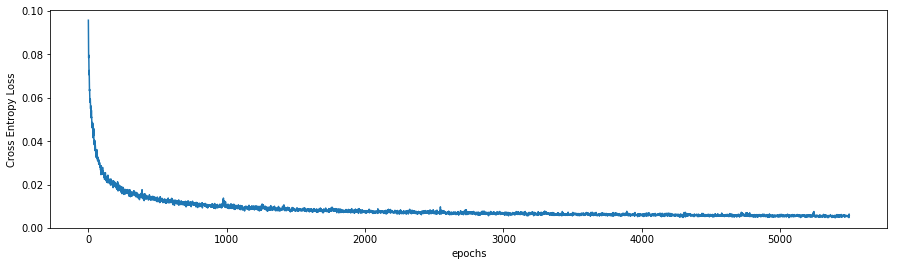

In [9]:
plt.figure(figsize=(15, 4))
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

9. 图像重构  
`重构性能较好，说明可以实现基于CNN的压缩编码，去燥能力一般`

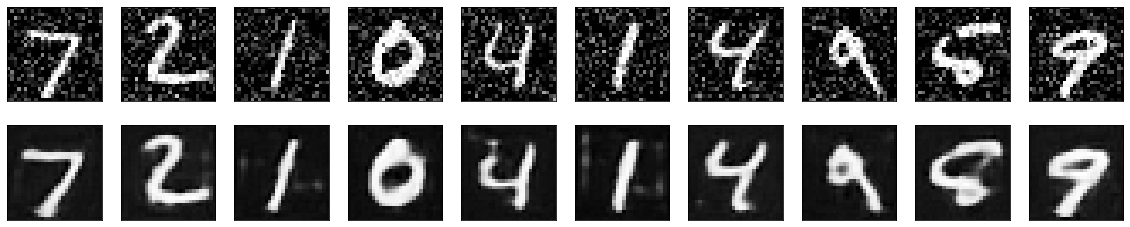

In [29]:
# fig, axes = plt.subplots(rows=2, cols=10, sharex=True, sharey=True, figsize=(20, 4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + 0.2 * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
reconstructed = sess.run(decoded, feed_dict={X: noisy_imgs.reshape((10, 28, 28, 1))})
row, col = 2, 10
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20, 4))
for images, row in zip([noisy_imgs, reconstructed], axarr):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

10. 关闭会话

In [30]:
sess.close()